In this project, we aim to build a predictive model to determine whether a hotel booking would be canceled, which is crucial for hotels as cancellations affect revenue and operational planning. The dataset contains a high number of features related to booking, such as lead time, deposit type, and special requests, which adds to the complexity of the model. The challenge lies in the data preprocessing steps, which include feature selection and engineering, handling missing values, and noise in the data. Additionally, we are going to train different models, evaluate their performance using the right metrics, and interpret the model by analyzing the most important features in the context of hotel booking cancellations.



In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': 'lavender'}, style='darkgrid')

In [13]:
# Read dataset
df = pd.read_csv('hotel_booking.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [22]:
# Based on the given dataset description, list the columns that are categorical in terms of their semantics
categorical_columns_semantics = [
    'hotel',
    'is_canceled',
    'arrival_date_year',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
    'name',
    'email',
    'phone-number',
    'credit_card'
]

# Convert these columns to string (object) data type
for column in categorical_columns_semantics:
    if column in df.columns:
        df[column] = df[column].astype(str)

# Verify the changes in data types
df.dtypes

hotel                              object
is_canceled                        object
lead_time                           int64
arrival_date_year                  object
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                  object
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [26]:
# Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0


In [32]:
# Get the summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
is_canceled,119390,2,0,75166
arrival_date_year,119390,3,2016,56707
arrival_date_month,119390,12,August,13877
meal,119390,5,BB,92310
country,119390,178,PRT,48590
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870
is_repeated_guest,119390,2,0,115580
reserved_room_type,119390,10,A,85994


## Feature Selection and Engineering

In [39]:
# Reload the dataset to retain the original data types of the variables
df = pd.read_csv('hotel_booking.csv')

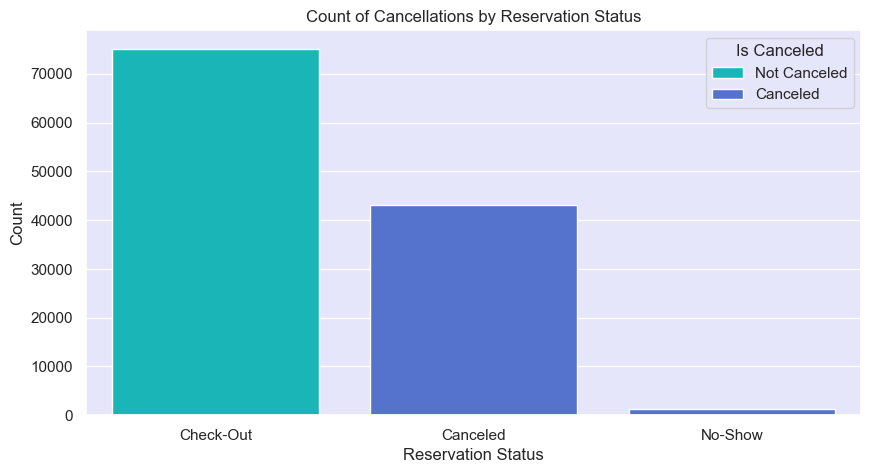

In [45]:
# Bivariate bar plot of 'is_canceled' vs 'reservation_status' with specified colors
plt.figure(figsize=(10, 5))
sns.countplot(x='reservation_status', hue='is_canceled', data=df, palette=['darkturquoise', 'royalblue'])
plt.title('Count of Cancellations by Reservation Status')
plt.xlabel('Reservation Status')
plt.ylabel('Count')
plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'])
plt.show()

In [47]:
df.groupby('reservation_status')['is_canceled'].mean()

reservation_status
Canceled     1.0
Check-Out    0.0
No-Show      1.0
Name: is_canceled, dtype: float64

In [50]:
# Drop the `reservation_status` feature
df = df.drop(['reservation_status'], axis=1)

In [55]:
# Convert 'reservation_status_date' to datetime format
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Extract Days_Difference from 'reservation_status_date'
df['reservation_status_days_difference'] = (df['reservation_status_date'] - pd.to_datetime(df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'] + '-' + df['arrival_date_day_of_month'].astype(str))).dt.days

df[['reservation_status_days_difference']].head()

,reservation_status_days_difference
0,0
1,0
2,1
3,1
4,2


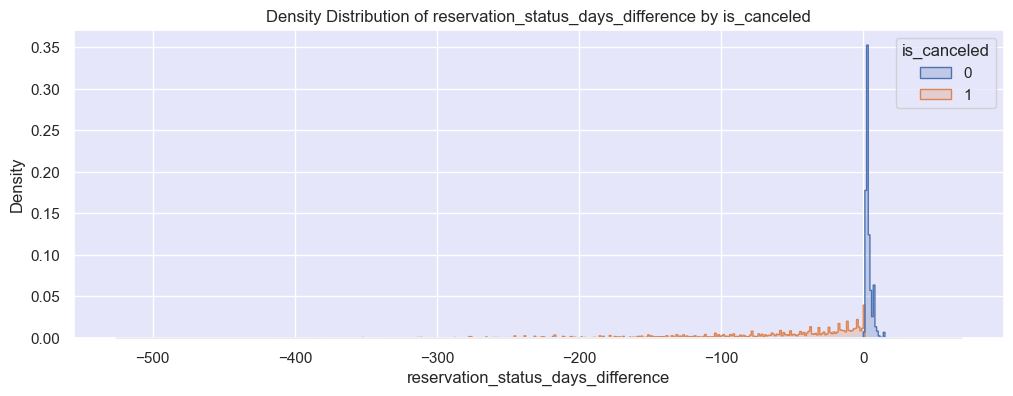

In [57]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x="reservation_status_days_difference", hue="is_canceled", element="step", stat="density", common_norm=False)
plt.title('Density Distribution of reservation_status_days_difference by is_canceled')
plt.show()

In [59]:
# For positive values of reservation_status_days_difference
print("Distribution of 'is_canceled' when 'reservation_status_days_difference' is positive:\n")
print(df[df['reservation_status_days_difference'] > 0]['is_canceled'].value_counts())

# For negative values of reservation_status_days_difference
print("\n" + "-"*85)
print("\nDistribution of 'is_canceled' when 'reservation_status_days_difference' is negative:\n")
print(df[df['reservation_status_days_difference'] < 0]['is_canceled'].value_counts())

Distribution of 'is_canceled' when 'reservation_status_days_difference' is positive:

is_canceled
0    74460
Name: count, dtype: int64

-------------------------------------------------------------------------------------

Distribution of 'is_canceled' when 'reservation_status_days_difference' is negative:

is_canceled
1    42137
Name: count, dtype: int64


In [62]:
# Drop the 'reservation_status_date' and 'reservation_status_days_difference' columns
df = df.drop(['reservation_status_date', 'reservation_status_days_difference'], axis=1)

In [66]:
df = df.drop(['assigned_room_type'], axis=1)

In [70]:
df['arrival_date_year'].value_counts()


arrival_date_year
2016    56707
2017    40687
2015    21996
Name: count, dtype: int64

In [72]:
# Drop the `arrival_date_year` feature
df = df.drop(['arrival_date_year'], axis=1)

In [76]:
# Create a dataframe with the number of unique categories and missing values for each high-cardinality feature
high_cardinality_features = ['country', 'agent', 'company', 'name', 'email', 'phone-number', 'credit_card']
unique_categories = df[high_cardinality_features].nunique()
missing_values = df[high_cardinality_features].isnull().sum()

# Combine the two series into a single dataframe
high_cardinality_df = pd.DataFrame({'Unique_Categories': unique_categories, 'Missing_Values': missing_values})

high_cardinality_df

,Unique_Categories,Missing_Values
country,177,488
agent,333,16340
company,352,112593
name,81503,0
email,115889,0
phone-number,119390,0
credit_card,9000,0


In [79]:
# Feature Engineering for 'name' feature
# Create a new feature representing the number of bookings made by each guest (based on the name)
df['number_of_bookings'] = df.groupby('name')['name'].transform('count')

# Drop the original 'name' feature and other high-cardinality features
df = df.drop(['name', 'country', 'agent', 'company', 'email', 'phone-number', 'credit_card'], axis=1)

df[['number_of_bookings']].head()

,number_of_bookings
0,1
1,2
2,3
3,1
4,1


## Handle Missing Values

In [83]:
# Calculate the missing values percentage in the original dataset
missing_values_percentage = (df.isnull().sum() / len(df)) * 100
missing_values_percentage[missing_values_percentage > 0]

children    0.00335
dtype: float64

In [86]:
df['children'].value_counts()

children
0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: count, dtype: int64

In [88]:
# Impute missing values in 'children' column with 0
df['children'] = df['children'].fillna(0)

# Check if there are any missing values left in 'children' column
df['children'].isnull().sum()

0

## Handle Noisy Data

In [92]:
# Analyze noisy data
noisy_data = {
    'adr':      df[df['adr'] < 0],
    'adults':   df[df['adults'] == 0],
    'children': df[df['children'] == 10],
    'babies':   df[df['babies'] == 10],
}

noisy_data_count = {key: len(value) for key, value in noisy_data.items()}
noisy_data_count

{'adr': 1, 'adults': 403, 'children': 1, 'babies': 1}

In [96]:
# Replace negative adr with median of adr column
df.loc[df['adr'] < 0, 'adr'] = df['adr'].median()

# Remove rows with 0 adults
df = df[df['adults'] != 0]

# Remove rows with 10 children or 10 babies
df = df[df['children'] != 10]
df = df[df['babies'] != 10]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Check if the noisy data has been handled
noisy_data_handled = {
    'adr': df[df['adr'] < 0],
    'adults': df[df['adults'] == 0],
    'children': df[df['children'] == 10],
    'babies': df[df['babies'] == 10],
}

noisy_data_handled_count = {key: len(value) for key, value in noisy_data_handled.items()}
noisy_data_handled_count

{'adr': 0, 'adults': 0, 'children': 0, 'babies': 0}

In [100]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list                int64
customer_type                      object
adr                               float64
required_car_parking_spaces       

In [103]:
# Convert 'arrival_date_month' to numerical values
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: months.index(x) + 1)

# One-hot encode the specified columns
one_hot_cols = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118985 entries, 0 to 118984
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118985 non-null  int64  
 1   lead_time                       118985 non-null  int64  
 2   arrival_date_month              118985 non-null  int64  
 3   arrival_date_week_number        118985 non-null  int64  
 4   arrival_date_day_of_month       118985 non-null  int64  
 5   stays_in_weekend_nights         118985 non-null  int64  
 6   stays_in_week_nights            118985 non-null  int64  
 7   adults                          118985 non-null  int64  
 8   children                        118985 non-null  float64
 9   babies                          118985 non-null  int64  
 10  is_repeated_guest               118985 non-null  int64  
 11  previous_cancellations          118985 non-null  int64  
 12  previous_booking

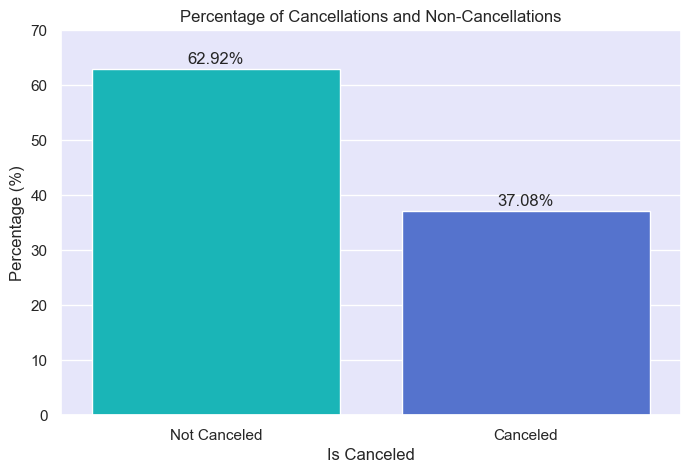

In [107]:
# Calculating the percentage of each class
percentage = df['is_canceled'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, palette=['darkturquoise', 'royalblue'])
plt.title('Percentage of Cancellations and Non-Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()


### Split the Dataset

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118985 entries, 0 to 118984
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118985 non-null  int64  
 1   lead_time                       118985 non-null  int64  
 2   arrival_date_month              118985 non-null  int64  
 3   arrival_date_week_number        118985 non-null  int64  
 4   arrival_date_day_of_month       118985 non-null  int64  
 5   stays_in_weekend_nights         118985 non-null  int64  
 6   stays_in_week_nights            118985 non-null  int64  
 7   adults                          118985 non-null  int64  
 8   children                        118985 non-null  float64
 9   babies                          118985 non-null  int64  
 10  is_repeated_guest               118985 non-null  int64  
 11  previous_cancellations          118985 non-null  int64  
 12  previous_booking

In [114]:
# Define the features (X) and the output labels (y)
X = df.drop('is_canceled', axis=1)
y = df['is_canceled'] 

In [116]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)


### Decision Tree Model Building


In [122]:
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

###  DT Hyperparameter Tuning

In [127]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [130]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [13, 14, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [133]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [135]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 2}, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


 ## DT Model Evaluation

In [139]:
def metrics_calculator(clf, X_test, y_test, model_name):
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [141]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     59897
           1       0.74      0.85      0.79     35291

    accuracy                           0.83     95188
   macro avg       0.82      0.84      0.83     95188
weighted avg       0.84      0.83      0.84     95188


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     14974
           1       0.70      0.81      0.75      8823

    accuracy                           0.80     23797
   macro avg       0.79      0.80      0.79     23797
weighted avg       0.81      0.80      0.81     23797



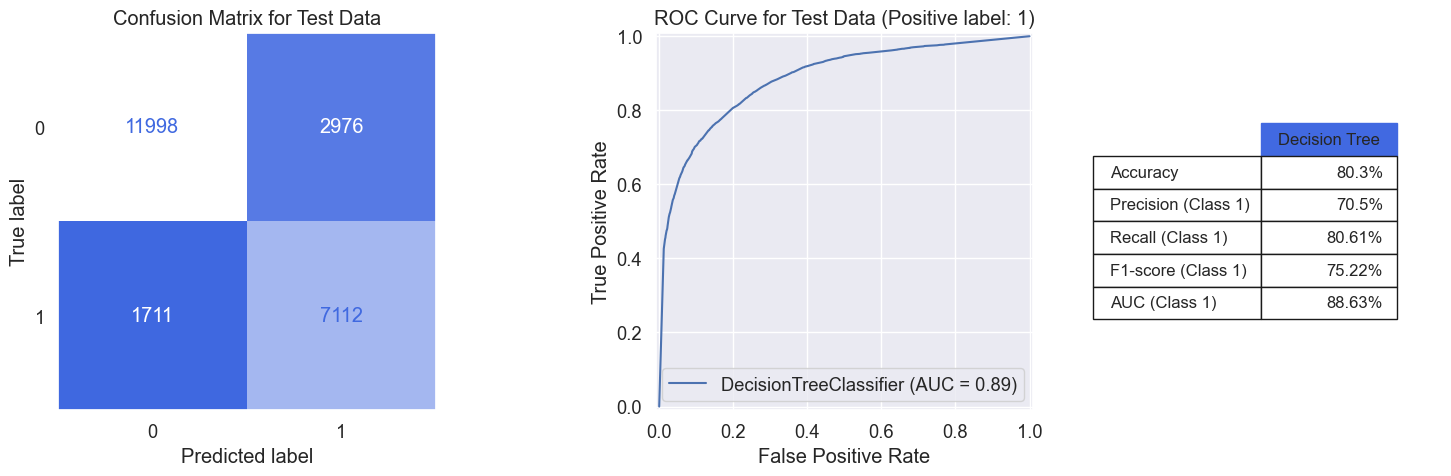

In [144]:
model_evaluation(best_dt, X_train, X_test, y_train, y_test, 'Decision Tree')

In [147]:
# Save the final performance of DT classifier
dt_result = metrics_calculator(best_dt, X_test, y_test, 'Decision Tree')
dt_result

,Decision Tree
Accuracy,80.3%
Precision (Class 1),70.5%
Recall (Class 1),80.61%
F1-score (Class 1),75.22%
AUC (Class 1),88.63%


## Random Forest Model Building



In [152]:
# Define the base RF model
rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)

### RF Hyperparameter Tuning</span>

In [156]:
param_grid_rf = {
    'n_estimators': [100, 150],
    'criterion': ['entropy'],
    'max_depth': [16, 18],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [158]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)

In [160]:
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 2}, 'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}


 ### RF Model Evaluation


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     59897
           1       0.80      0.85      0.83     35291

    accuracy                           0.87     95188
   macro avg       0.86      0.86      0.86     95188
weighted avg       0.87      0.87      0.87     95188


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     14974
           1       0.77      0.79      0.78      8823

    accuracy                           0.84     23797
   macro avg       0.83      0.83      0.83     23797
weighted avg       0.84      0.84      0.84     23797



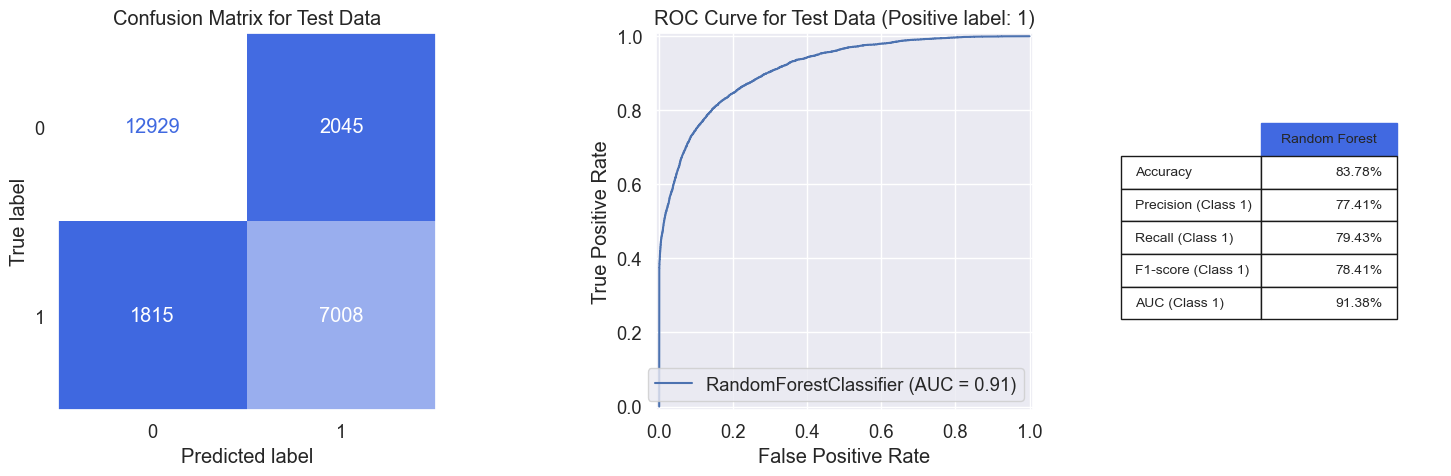

In [164]:
model_evaluation(best_rf, X_train, X_test, y_train, y_test, 'Random Forest')

In [167]:
# Save the final performance of RF classifier
rf_result = metrics_calculator(best_rf, X_test, y_test, 'Random Forest')
rf_result

,Random Forest
Accuracy,83.78%
Precision (Class 1),77.41%
Recall (Class 1),79.43%
F1-score (Class 1),78.41%
AUC (Class 1),91.38%


### XGBoost Model Building

###  XGBoost Base Model Definition

In [173]:
# Define the model
xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

### XGBoost Hyperparameter Tuning

In [178]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [250, 350],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
}

In [180]:
# Call the function for hyperparameter tuning
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, param_grid_xgb, X_train, y_train)

In [182]:
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

XGBoost Optimal Hyperparameters: 
 {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 350, 'scale_pos_weight': 1.697231588790343, 'subsample': 0.7}



## XGBoost Model Evaluation


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     59897
           1       0.86      0.88      0.87     35291

    accuracy                           0.90     95188
   macro avg       0.90      0.90      0.90     95188
weighted avg       0.90      0.90      0.90     95188


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     14974
           1       0.79      0.79      0.79      8823

    accuracy                           0.85     23797
   macro avg       0.84      0.84      0.84     23797
weighted avg       0.85      0.85      0.85     23797



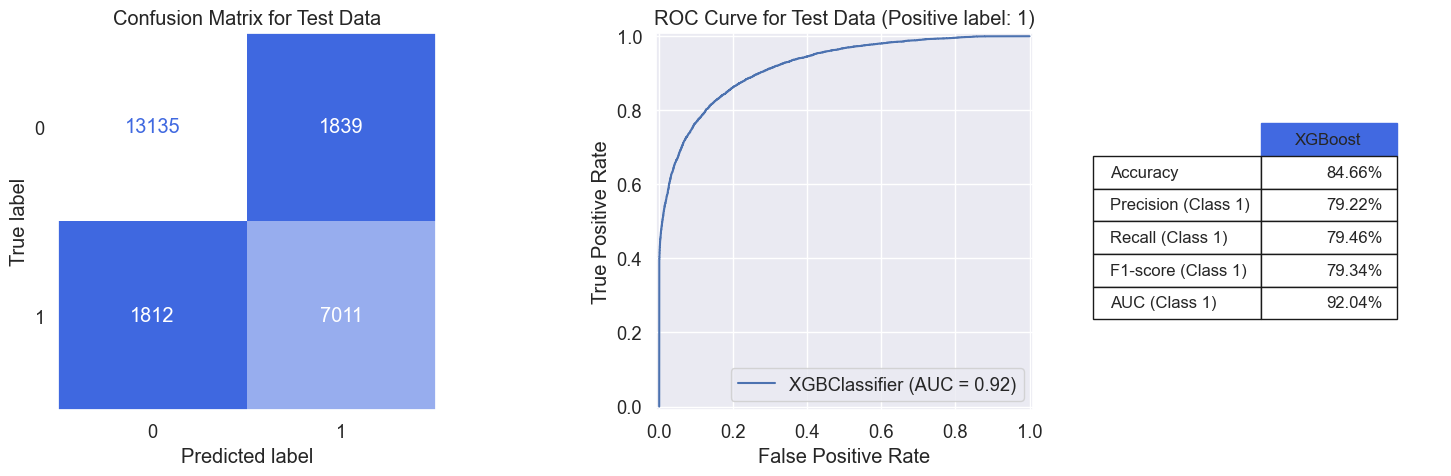

In [186]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

In [189]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(best_xgb, X_test, y_test, 'XGBoost')
xgb_result

,XGBoost
Accuracy,84.66%
Precision (Class 1),79.22%
Recall (Class 1),79.46%
F1-score (Class 1),79.34%
AUC (Class 1),92.04%


###  XGBoost Feature Importance 


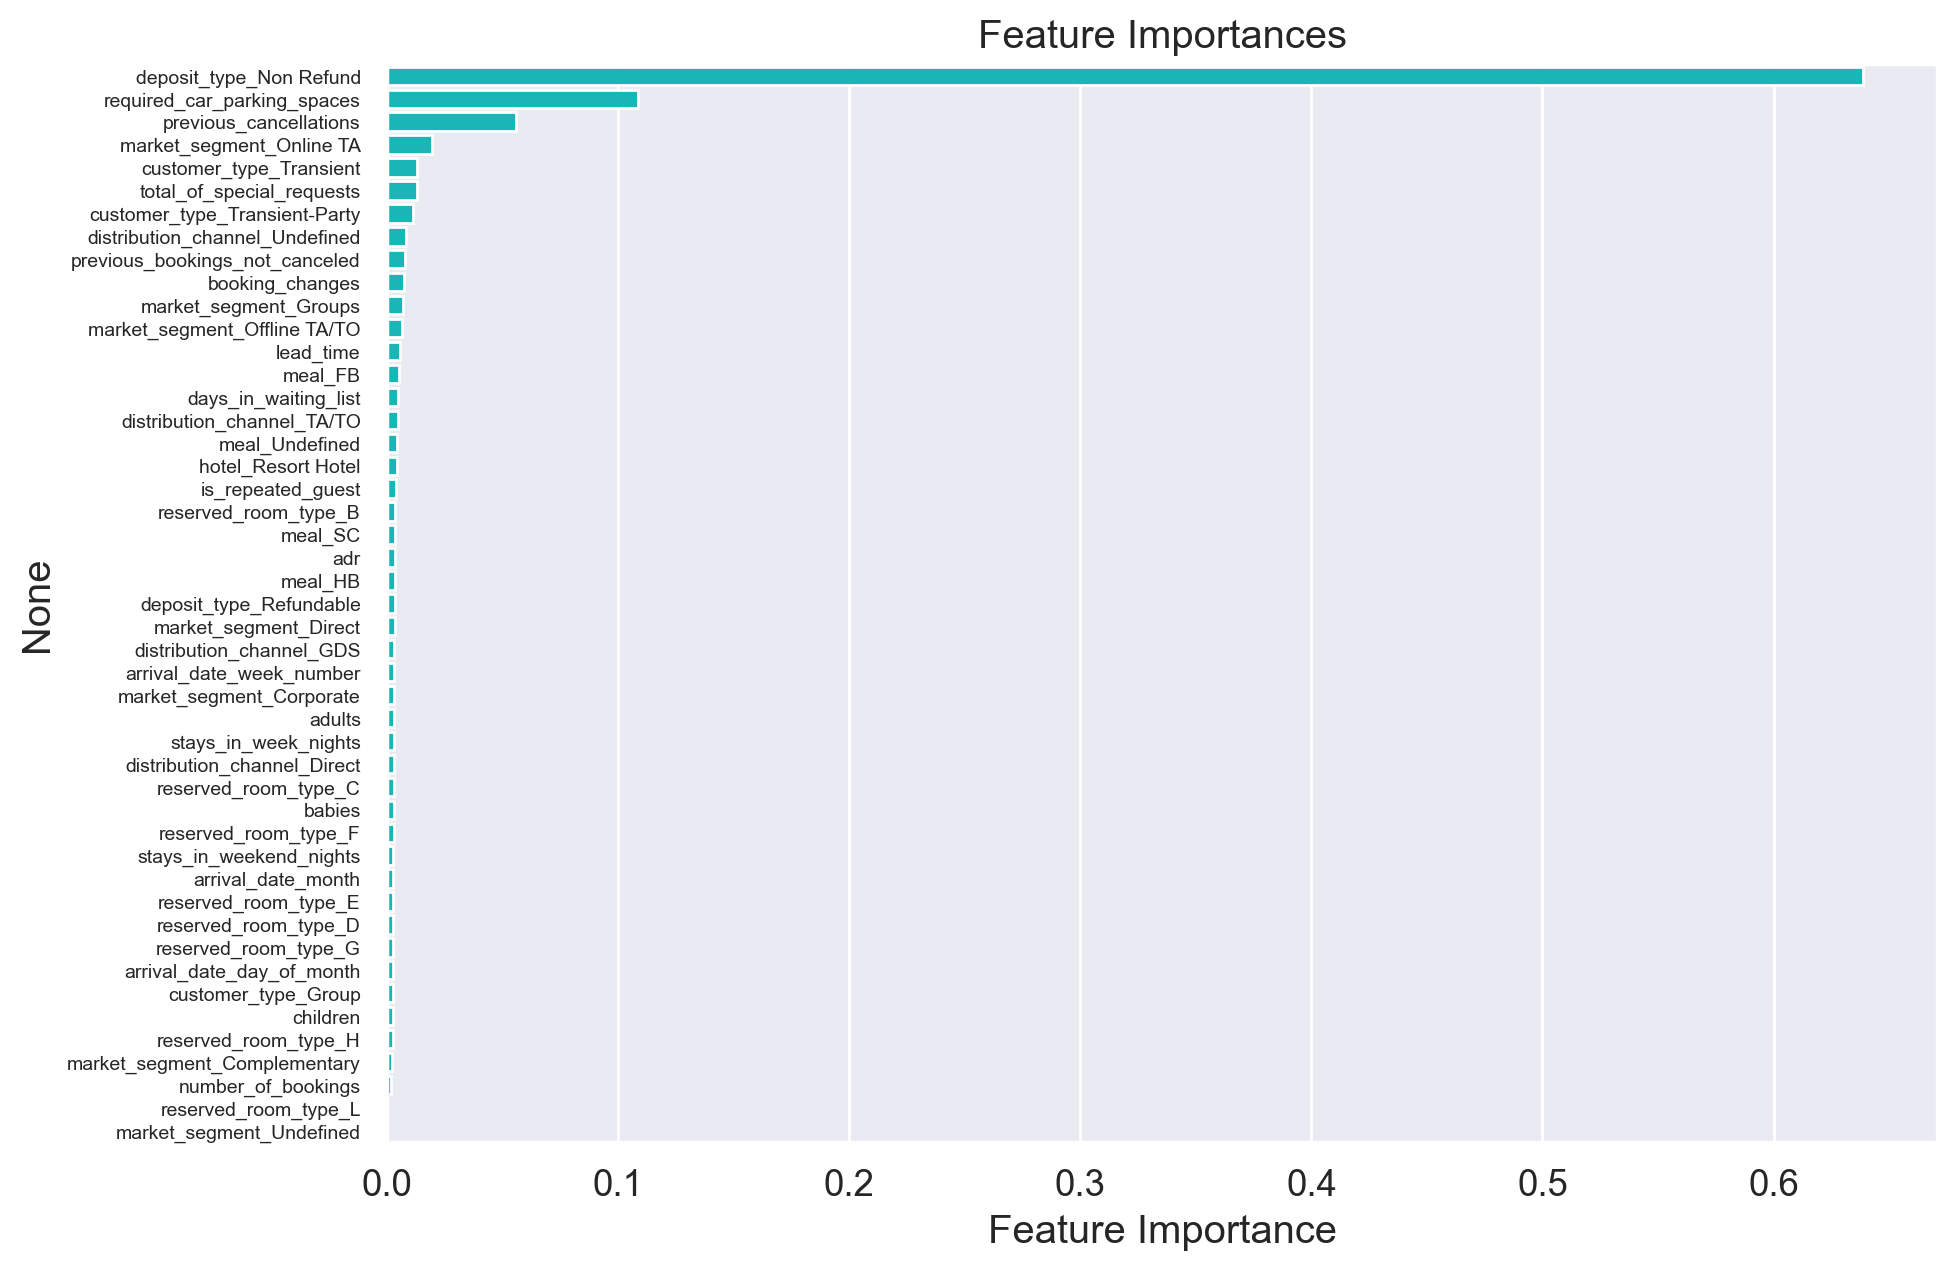

In [193]:
# Compute feature importances
feature_importances = best_xgb.feature_importances_

# Sort the feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 7), dpi=200)
sns.barplot(x=feature_importances[sorted_indices], y=X.columns[sorted_indices], color='darkturquoise')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.yticks(fontsize=7)
plt.show()

In [198]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([dt_result, rf_result, xgb_result], axis=1).T

# Sort the dataframe in descending order based on F1-score (class 1) values
results.sort_values(by='F1-score (Class 1)', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score (Class 1)')

,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1),AUC (Class 1)
XGBoost,84.66%,79.22%,79.46%,79.34%,92.04%
Random Forest,83.78%,77.41%,79.43%,78.41%,91.38%
Decision Tree,80.3%,70.5%,80.61%,75.22%,88.63%




Below, the F1-score for class '1' (canceled) of all previously evaluated classifiers is illustrated in a bar chart:

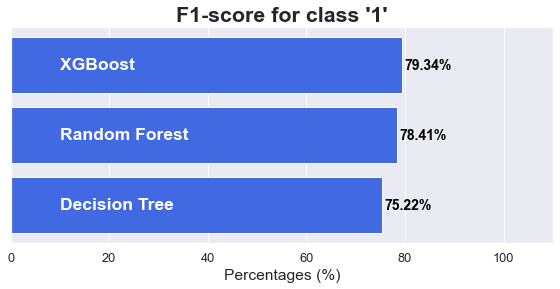

In [201]:
# Prepare values
results.sort_values(by='F1-score (Class 1)', ascending=True, inplace=True)
f1_scores = results['F1-score (Class 1)'].str.strip('%').astype(float)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 4), dpi=70)
ax.barh(results.index, f1_scores, color='royalblue')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(f1_scores, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='black')
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0,110])

# Add title and xlabel
plt.title("F1-score for class '1'", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

Conclusion 

Among all the tested classifiers, __XGBoost__ had the best performance in predicting hotel booking cancellations:

Accuracy = 85.04%
F1-score (Class 1) = 79.85%
Precision (Class 1) = 79.76%
Recall (Class 1) = 79.94%
AUC (Class 1) = 92.17%